Continuing the work from the same note on 01/25, I'm re-running XHMM to remove targets with high GC content and also low complexity. Like the previous analysis, I'll run only the simplex families with at least 2 kids in them, for the contrast between affected and unaffected. Also have to remember to remove the other 2 samples we always remove.

Now we create PSEQ and PLINK files.

In [2]:
module load plinkseq
module load plink/1.07

cd ~/data/cnv/xhmm_clean

pseq DATA new-project
# adding a first column with subject ID for PSEQ
cut -f 2 ../simplex.ped > junk.txt
paste junk.txt ../simplex.ped > simplex.ped.info
pseq DATA load-pedigree --file simplex.ped.info
pseq DATA load-vcf --vcf DATA.vcf

for q in 50 60 70 80 90; do
    pseq DATA cnv-denovo --noweb --minSQ $q --minNQ $q --out DATA_q${q}
    grep DENOVO DATA_q${q}.denovo.cnv > pseq_DENOVO.txt
    # borrow the header row
    head -1 DATA.xcnv > denovo.xcnv;

    # filter out denovo CNVs
    while read sample; do
        grep $sample DATA.xcnv > sample.xcnv;
        for cnv in `grep $sample pseq_DENOVO.txt | cut -f 3 -`; do
            # replacing .. by -
            cnv=`echo $cnv | sed -e 's/\.\./\-/'`;
            grep $cnv sample.xcnv >> denovo.xcnv; 
        done;
    done < ../kid_samples.txt;
    /usr/local/apps/XHMM/2016-01-04/sources/scripts/xcnv_to_cnv denovo.xcnv > tmp.cnv
    # switch around FAMID and IID columns, and remove header
    awk '{OFS="\t"; if ( $3 != "CHR" ) {print $2, $1, $3, $4, $5, $6, $7, $8 }}' tmp.cnv > denovo_q${q}.cnv
    rm sample.xcnv pseq_DENOVO.txt tmp.cnv denovo.xcnv
    
    # filter out inherited cnvs
    grep MATERNAL_TRANSMITTED DATA_q${q}.denovo.cnv > pseq_TRANSMITTED.txt
    grep PATERNAL_TRANSMITTED DATA_q${q}.denovo.cnv >> pseq_TRANSMITTED.txt
    # borrow the header row
    head -1 DATA.xcnv > inherited.xcnv;

    while read sample; do
        grep $sample DATA.xcnv > sample.xcnv;
        for cnv in `grep $sample pseq_TRANSMITTED.txt | cut -f 3 -`; do
            # replacing .. by -
            cnv=`echo $cnv | sed -e 's/\.\./\-/'`;
            grep $cnv sample.xcnv >> inherited.xcnv; 
        done;
    done < ../kid_samples.txt;
    /usr/local/apps/XHMM/2016-01-04/sources/scripts/xcnv_to_cnv inherited.xcnv > tmp.cnv
    # switch around FAMID and IID columns, and remove header
    awk '{OFS="\t"; if ( $3 != "CHR" ) {print $2, $1, $3, $4, $5, $6, $7, $8 }}' tmp.cnv > inherited_q${q}.cnv
    rm sample.xcnv pseq_TRANSMITTED.txt tmp.cnv inherited.xcnv
    
    # compile all CNVs for kids
    # borrow the header row
    head -1 DATA.xcnv > all.xcnv;

    # effectively just filtering DATA.xcnv to keep only kids
    while read sample; do
        grep $sample DATA.xcnv >> all.xcnv;
    done < ../kid_samples.txt;
    /usr/local/apps/XHMM/2016-01-04/sources/scripts/xcnv_to_cnv all.xcnv > tmp.cnv
    # switch around FAMID and IID columns, and remove header
    awk '{OFS="\t"; if ( $3 != "CHR" ) {print $2, $1, $3, $4, $5, $6, $7, $8 }}' tmp.cnv > all_q${q}.cnv
    rm tmp.cnv all.xcnv
done

[-] Unloading GSL 2.2.1 ...
[-] Unloading Graphviz v2.38.0 ...
[-] Unloading gdal 2.0 ...
[-] Unloading proj 4.9.2 ...
[-] Unloading gcc 4.9.1 ...
[-] Unloading openmpi 1.10.0 for GCC 4.9.1
[-] Unloading tcl_tk 8.6.3
[-] Unloading Zlib 1.2.8 ...
[-] Unloading Bzip2 1.0.6 ...
[-] Unloading pcre 8.38 ...
[-] Unloading liblzma 5.2.2 ...
[-] Unloading libjpeg-turbo 1.5.1 ...
[-] Unloading tiff 4.0.7 ...
[-] Unloading curl 7.46.0 ...
[-] Unloading boost libraries v1.65 ...
[-] Unloading R 3.4.0 on cn3254
[+] Loading GSL 2.2.1 ...
[+] Loading Graphviz v2.38.0 ...
[+] Loading gdal 2.0 ...
[+] Loading proj 4.9.2 ...
[+] Loading gcc 4.9.1 ...
[+] Loading openmpi 1.10.0 for GCC 4.9.1
[+] Loading tcl_tk 8.6.3
[+] Loading Zlib 1.2.8 ...
[+] Loading Bzip2 1.0.6 ...
[+] Loading pcre 8.38 ...
[+] Loading liblzma 5.2.2 ...
[-] Unloading Zlib 1.2.8 ...
[+] Loading Zlib 1.2.8 ...
[-] Unloading liblzma 5.2.2 ...
[+] Loading liblzma 5.2.2 ...
[+] Loading libjpeg-turbo 1.5.1 ...
[+] Loading tiff 4.0.7 ...


In [ ]:
cp ~/data/cnv/penncnv/wellknown_region_hg19 bad_regions.list
cp ~/data/cnv/penncnv/glist-hg19 .
cp ~/data/cnv/penncnv/genes.txt .
cp ~/data/cnv/penncnv/hg19_allenBrainGene_trimmed.txt .

for q in 50 60 70 80 90; do
    for cnvtype in all denovo inherited; do
        cnvname=${cnvtype}_q${q}.cnv
        plink --cnv-list $cnvname --cnv-make-map --noweb --out ${cnvtype}_q${q};
        
        # remove bad regions
        plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
            --noweb --1 --cnv-exclude bad_regions.list --cnv-overlap .5 \
            --cnv-write --out ${cnvtype}_q${q}_clean
        plink --cnv-list ${cnvtype}_q${q}_clean.cnv --cnv-make-map --noweb --1 \
            --out ${cnvtype}_q${q}_clean
        
        for qc in '' '_clean'; do
            cnvname=${cnvtype}_q${q}${qc}.cnv
            # whole burden
            plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-check-no-overlap --out ${cnvtype}_q${q}${qc}_burden;
            # gene sets
            plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset genes.txt --out ${cnvtype}_q${q}${qc}_genes;
            plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset hg19_allenBrainGene_trimmed.txt \
                --out ${cnvtype}_q${q}${qc}_brainGenes;
            # subtypes only
            for sub in del dup; do
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-${sub} --out ${cnvtype}_q${q}${qc}_${sub}Burden;
                # gene sets
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset genes.txt --cnv-${sub} \
                    --out ${cnvtype}_q${q}${qc}_${sub}Genes;
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-${sub} \
                    --out ${cnvtype}_q${q}${qc}_${sub}BrainGenes;
            done;
        done;
    done;
done


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q50.log ]
Analysis started: Fri Jan 26 15:09:00 2018

Options in effect:
	--cnv-list all_q50.cnv
	--cnv-make-map
	--noweb
	--out all_q50


Reading segment list (CNVs) from [ all_q50.cnv ]
Writing new MAP file to [ all_q50.cnv.map ]
Wrote 10101 unique positions to file

Analysis finished: Fri Jan 26 15:09:00 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|

Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_q50_brainGenes.notfound ] 

Reading segment list (CNVs) from [ all_q50.cnv ]
Writing back list to intersected regions to [ all_q50_brainGenes.reg ]
6924 mapped to a person, of which 6924 passed filters
54 intersected with one or more specified region
54 of 6924 mapped as valid segments
 CopyN Case/Control
     1      14 / 11
     3      13 / 16

Writing per-individual summary to [ all_q50_brainGenes.cnv.indiv ]
Writing positional summary to [ all

 CopyN Case/Control
     3  1532 / 1947

Writing per-individual summary to [ all_q50_dupBurden.cnv.indiv ]
Writing positional summary to [ all_q50_dupBurden.cnv.summary ]

Analysis finished: Fri Jan 26 15:10:38 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q50_dupGenes.log ]
Analysis started: Fri Jan 26 15:10:38 2018

Options in effect:
	--map all_q50.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_q50.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report

|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q50_clean_brainGenes.log ]
Analysis started: Fri Jan 26 15:10:41 2018

Options in effect:
	--map all_q50_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_q50_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--out all_q50_clean_brainGenes

Reading marker information from [ all_q50_clean.cnv.map ]
429 (of 429) markers to be included from [ all_q50_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simpl

|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q50_clean_dupBurden.log ]
Analysis started: Fri Jan 26 15:10:42 2018

Options in effect:
	--map all_q50_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_q50_clean.cnv
	--noweb
	--1
	--cnv-dup
	--out all_q50_clean_dupBurden

Reading marker information from [ all_q50_clean.cnv.map ]
429 (of 429) markers to be included from [ all_q50_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (C


Analysis finished: Fri Jan 26 15:10:56 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q50_clean.log ]
Analysis started: Fri Jan 26 15:10:56 2018

Options in effect:
	--cnv-list denovo_q50_clean.cnv
	--cnv-make-map
	--noweb
	--1
	--out denovo_q50_clean


Reading segment list (CNVs) from [ denovo_q50_clean.cnv ]
Writing new MAP file to [ denovo_q50_clean.cnv.map ]
Wrote 208 unique positions to file

Analysis finished: Fri Jan 26 15:10:56 2018


@----------------------------

 CopyN Case/Control
     1    331 / 236

Writing per-individual summary to [ denovo_q50_delBurden.cnv.indiv ]
Writing positional summary to [ denovo_q50_delBurden.cnv.summary ]

Analysis finished: Fri Jan 26 15:10:57 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q50_delGenes.log ]
Analysis started: Fri Jan 26 15:10:57 2018

Options in effect:
	--map denovo_q50.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo_q50.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv

|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q50_dupBrainGenes.log ]
Analysis started: Fri Jan 26 15:10:59 2018

Options in effect:
	--map denovo_q50.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo_q50.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-dup
	--out denovo_q50_dupBrainGenes

Reading marker information from [ denovo_q50.cnv.map ]
2582 (of 2582) markers to be included from [ denovo_q50.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofa

|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q50_clean_delBurden.log ]
Analysis started: Fri Jan 26 15:10:59 2018

Options in effect:
	--map denovo_q50_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo_q50_clean.cnv
	--noweb
	--1
	--cnv-del
	--out denovo_q50_clean_delBurden

Reading marker information from [ denovo_q50_clean.cnv.map ]
208 (of 208) markers to be included from [ denovo_q50_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Readi


Reading marker information from [ denovo_q50_clean.cnv.map ]
208 (of 208) markers to be included from [ denovo_q50_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ denovo_q50_clean.cnv ]
Writing back list to intersected regions to [ denovo_q50_clean_dupGenes.reg ]
75 mapped to a person, of which 22 passed filters
21 intersected with one or more specified region
21 of 75 mapped as valid segments
 CopyN Case/Control
     3      11 / 10

Writing per-in

21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ inherited_q50.cnv ]
No overlapping samples found
446 mapped to a person, of which 446 passed filters
446 of 446 mapped as valid segments
 CopyN Case/Control
     1    121 / 131
     3      96 / 98

Writing per-individual summary to [ inherited_q50_burden.cnv.indiv ]
Writing positional summary to [ inherited_q50_burden.cnv.summary ]

Analysis finished: Fri Jan 26 15:11:07 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping we


Writing per-individual summary to [ inherited_q50_delGenes.cnv.indiv ]
Writing positional summary to [ inherited_q50_delGenes.cnv.summary ]

Analysis finished: Fri Jan 26 15:11:08 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q50_delBrainGenes.log ]
Analysis started: Fri Jan 26 15:11:08 2018

Options in effect:
	--map inherited_q50.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list inherited_q50.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-region


Analysis finished: Fri Jan 26 15:11:09 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q50_clean_burden.log ]
Analysis started: Fri Jan 26 15:11:09 2018

Options in effect:
	--map inherited_q50_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list inherited_q50_clean.cnv
	--noweb
	--1
	--cnv-check-no-overlap
	--out inherited_q50_clean_burden

Reading marker information from [ inherited_q50_clean.cnv.map ]
15 (of 15) markers to be included from [ inherited_q50_clean.cn

@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q50_clean_delGenes.log ]
Analysis started: Fri Jan 26 15:11:09 2018

Options in effect:
	--map inherited_q50_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list inherited_q50_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-del
	--out inherited_q50_clean_delGenes

Reading marker information from [ inherited_q50_clean.cnv.map ]
15 (of 15) markers to be included from [ inherited_q50_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list

Writing this text to log file [ inherited_q50_clean_dupBrainGenes.log ]
Analysis started: Fri Jan 26 15:11:10 2018

Options in effect:
	--map inherited_q50_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list inherited_q50_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-dup
	--out inherited_q50_clean_dupBrainGenes

Reading marker information from [ inherited_q50_clean.cnv.map ]
15 (of 15) markers to be included from [ inherited_q50_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 6

Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ all_q60.cnv ]
Writing back list to intersected regions to [ all_q60_genes.reg ]
6924 mapped to a person, of which 6924 passed filters
5942 intersected with one or more specified region
5942 of 6924 mapped as valid segments
 CopyN Case/Control
     1  1474 / 1481
     3  1297 / 1690

Writing per-individual summary to [ all_q60_genes.cnv.indiv ]
Writing positional summary to [ all_q60_genes.cnv.summary ]

Analysis finished: Fri Jan 26 15:12:49 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, ci

25 intersected with one or more specified region
25 of 6924 mapped as valid segments
 CopyN Case/Control
     1      14 / 11

Writing per-individual summary to [ all_q60_delBrainGenes.cnv.indiv ]
Writing positional summary to [ all_q60_delBrainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 15:12:53 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q60_dupBurden.log ]
Analysis started: Fri Jan 26 15:12:53 2018

Options in effect:
	--map all_q60.cnv.map
	--fam ../simplex_nofam


Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q60_clean_genes.log ]
Analysis started: Fri Jan 26 15:12:56 2018

Options in effect:
	--map all_q60_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_q60_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--out all_q60_clean_genes

Reading marker information from [ all_q60_clean.cnv.map ]
429 (of 429) markers to be included from [ all_q60_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25

	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-del
	--out all_q60_clean_delBrainGenes

Reading marker information from [ all_q60_clean.cnv.map ]
429 (of 429) markers to be included from [ all_q60_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_q60_clean_delBrainGenes.notfound ] 

Reading segment list (CNVs) from [ all_q60_clean.cnv ]
Writing back list to intersected regions to [ a

|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q60_clean.log ]
Analysis started: Fri Jan 26 15:12:58 2018

Options in effect:
	--map denovo_q60.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo_q60.cnv
	--noweb
	--1
	--cnv-exclude bad_regions.list
	--cnv-overlap .5
	--cnv-write
	--out denovo_q60_clean

Reading marker information from [ denovo_q60.cnv.map ]
1753 (of 1753) markers to be included from [ denovo_q60.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nof

9 of 672 mapped as valid segments
 CopyN Case/Control
     1        3 / 3
     3        2 / 1

Writing per-individual summary to [ denovo_q60_brainGenes.cnv.indiv ]
Writing positional summary to [ denovo_q60_brainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 15:13:09 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q60_delBurden.log ]
Analysis started: Fri Jan 26 15:13:09 2018

Options in effect:
	--map denovo_q60.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo


Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q60_dupGenes.log ]
Analysis started: Fri Jan 26 15:13:10 2018

Options in effect:
	--map denovo_q60.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo_q60.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-dup
	--out denovo_q60_dupGenes

Reading marker information from [ denovo_q60.cnv.map ]
1753 (of 1753) markers to be included from [ denovo_q60.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 2

	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--out denovo_q60_clean_brainGenes

Reading marker information from [ denovo_q60_clean.cnv.map ]
143 (of 143) markers to be included from [ denovo_q60_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ denovo_q60_clean_brainGenes.notfound ] 

Reading segment list (CNVs) from [ denovo_q60_clean.cnv ]
Writing

143 (of 143) markers to be included from [ denovo_q60_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ denovo_q60_clean.cnv ]
51 mapped to a person, of which 12 passed filters
12 of 51 mapped as valid segments
 CopyN Case/Control
     3        8 / 4

Writing per-individual summary to [ denovo_q60_clean_dupBurden.cnv.indiv ]
Writing positional summary to [ denovo_q60_clean_dupBurden.cnv.summary ]

Analysis finished: Fri Jan 26 15:13:11 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 

@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q60_clean.log ]
Analysis started: Fri Jan 26 15:13:18 2018

Options in effect:
	--cnv-list inherited_q60_clean.cnv
	--cnv-make-map
	--noweb
	--1
	--out inherited_q60_clean


Reading segment list (CNVs) from [ inherited_q60_clean.cnv ]
Writing new MAP file to [ inherited_q60_clean.cnv.map ]
Wrote 15 unique positions to file

Analysis finished: Fri Jan 26 15:13:18 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@



|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q60_delGenes.log ]
Analysis started: Fri Jan 26 15:13:19 2018

Options in effect:
	--map inherited_q60.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list inherited_q60.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-del
	--out inherited_q60_delGenes

Reading marker information from [ inherited_q60.cnv.map ]
739 (of 739) markers to be included from [ inherited_q60.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 in


Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q60_dupBrainGenes.log ]
Analysis started: Fri Jan 26 15:13:20 2018

Options in effect:
	--map inherited_q60.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list inherited_q60.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-dup
	--out inherited_q60_dupBrainGenes

Reading marker information from [ inherited_q60.cnv.map ]
739 (of 739) markers to be included from [ inherited_q60.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of


Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q60_clean_delBurden.log ]
Analysis started: Fri Jan 26 15:13:20 2018

Options in effect:
	--map inherited_q60_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list inherited_q60_clean.cnv
	--noweb
	--1
	--cnv-del
	--out inherited_q60_clean_delBurden

Reading marker information from [ inherited_q60_clean.cnv.map ]
15 (of 15) markers to be included from [ inherited_q60_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ inherited_q60_clean.cnv ]
5 mapped to a person, of which 4 passed filters
4 of 5 mapped as valid segments
 CopyN Case/Control
     1     

Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ inherited_q60_clean.cnv ]
Writing back list to intersected regions to [ inherited_q60_clean_dupGenes.reg ]
5 mapped to a person, of which 1 passed filters
1 intersected with one or more specified region
1 of 5 mapped as valid segments
 CopyN Case/Control
     3        1 / 0

Writing per-individual summary to [ inherited_q60_clean_dupGenes.cnv.indiv ]
Writing positional summary to [ inherited_q60_clean_dupGenes.cnv.sum

6924 of 6924 mapped as valid segments
 CopyN Case/Control
     1  1698 / 1747
     3  1532 / 1947

Writing per-individual summary to [ all_q70_burden.cnv.indiv ]
Writing positional summary to [ all_q70_burden.cnv.summary ]

Analysis finished: Fri Jan 26 15:14:48 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q70_genes.log ]
Analysis started: Fri Jan 26 15:14:48 2018

Options in effect:
	--map all_q70.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_q70.cnv
	--noweb
	--1


|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q70_delBrainGenes.log ]
Analysis started: Fri Jan 26 15:14:58 2018

Options in effect:
	--map all_q70.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_q70.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-del
	--out all_q70_delBrainGenes

Reading marker information from [ all_q70.cnv.map ]
10101 (of 10101) markers to be included from [ all_q70.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease pheno

Analysis started: Fri Jan 26 15:15:02 2018

Options in effect:
	--map all_q70_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_q70_clean.cnv
	--noweb
	--1
	--cnv-check-no-overlap
	--out all_q70_clean_burden

Reading marker information from [ all_q70_clean.cnv.map ]
429 (of 429) markers to be included from [ all_q70_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ all_q70_clean.cnv ]
No overlapping samples found
170 mapped to a person, of which 170 passed filters
170 of 170 mapped as valid segments
 CopyN Case/Control
     1      78 / 25
     3      25 / 42

Writing per-individual summary to [ all_q70_clean_burden.cnv.

Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ all_q70_clean.cnv ]
Writing back list to intersected regions to [ all_q70_clean_delGenes.reg ]
170 mapped to a person, of which 103 passed filters
100 intersected with one or more specified region
100 of 170 mapped as valid segments
 CopyN Case/Control
     1      75 / 25

Writing per-individual summary to [ all_q70_clean_delGenes.cnv.indiv ]
Writing positional summary to [ all_q70_clean_delGenes.cnv.summary ]

Analysis finished: Fri Jan 26 15:15:03 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|---------------------------------------------------------

Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_q70_clean_dupBrainGenes.notfound ] 

Reading segment list (CNVs) from [ all_q70_clean.cnv ]
Writing back list to intersected regions to [ all_q70_clean_dupBrainGenes.reg ]
170 mapped to a person, of which 67 passed filters
1 intersected with one or more specified region
1 of 170 mapped as valid segments
 CopyN Case/Control
     3        1 / 0

Writing per-individual summary to [ all_q70_clean_dupBrainGenes.cnv.indiv ]
Writing positional summary to [ all_q70_clean_dupBrainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 15:15:03 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For 

|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q70_brainGenes.log ]
Analysis started: Fri Jan 26 15:15:11 2018

Options in effect:
	--map denovo_q70.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo_q70.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--out denovo_q70_brainGenes

Reading marker information from [ denovo_q70.cnv.map ]
1065 (of 1065) markers to be included from [ denovo_q70.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenot

Writing this text to log file [ denovo_q70_dupBurden.log ]
Analysis started: Fri Jan 26 15:15:11 2018

Options in effect:
	--map denovo_q70.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo_q70.cnv
	--noweb
	--1
	--cnv-dup
	--out denovo_q70_dupBurden

Reading marker information from [ denovo_q70.cnv.map ]
1065 (of 1065) markers to be included from [ denovo_q70.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ denovo_q70.cnv ]
399 mapped to a person, of which 150 passed filters
150 of 399 mapped as valid segments
 CopyN Case/Control
     3      68 / 82

Writing per-individual summary to [ denovo_q70_dupBurden.cnv.indiv ]
Writing 

Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ denovo_q70_clean.cnv ]
Writing back list to intersected regions to [ denovo_q70_clean_genes.reg ]
36 mapped to a person, of which 36 passed filters
35 intersected with one or more specified region
35 of 36 mapped as valid segments
 CopyN Case/Control
     1       27 / 2
     3        4 / 2

Writing per-individual summary to [ denovo_q70_clean_genes.cnv.indiv ]
Writing positional summary to [ denovo_q70_clean_genes.cnv.summary ]

Analysis finished: Fri Jan 26 15:15:12 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|---------------------------------------

Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ denovo_q70_clean_delBrainGenes.notfound ] 

Reading segment list (CNVs) from [ denovo_q70_clean.cnv ]
Writing back list to intersected regions to [ denovo_q70_clean_delBrainGenes.reg ]
36 mapped to a person, of which 30 passed filters
0 intersected with one or more specified region
0 of 36 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ denovo_q70_clean_delBrainGenes.cnv.indiv ]
Writing positional summary to [ denovo_q70_clean_delBrainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 15:15:12 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|-----------------------------------------

	--map inherited_q70.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list inherited_q70.cnv
	--noweb
	--1
	--cnv-exclude bad_regions.list
	--cnv-overlap .5
	--cnv-write
	--out inherited_q70_clean

Reading marker information from [ inherited_q70.cnv.map ]
646 (of 646) markers to be included from [ inherited_q70.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading CNV intersection list from [ bad_regions.list ]
Read 380994 ranges to exclude from CNV list

Reading segment list (CNVs) from [ inherited_q70.cnv ]
319 mapped to a person, of which 319 passed filters
5 kept after excluding specific regions
5 of 319 mapped as valid segments
 CopyN Case/Control
     1        2 / 

|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q70_delBurden.log ]
Analysis started: Fri Jan 26 15:15:19 2018

Options in effect:
	--map inherited_q70.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list inherited_q70.cnv
	--noweb
	--1
	--cnv-del
	--out inherited_q70_delBurden

Reading marker information from [ inherited_q70.cnv.map ]
646 (of 646) markers to be included from [ inherited_q70.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=af


Reading marker information from [ inherited_q70.cnv.map ]
646 (of 646) markers to be included from [ inherited_q70.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ inherited_q70.cnv ]
Writing back list to intersected regions to [ inherited_q70_dupGenes.reg ]
319 mapped to a person, of which 130 passed filters
104 intersected with one or more specified region
104 of 319 mapped as valid segments
 CopyN Case/Control
     3      53 / 51

Writing per-individua

Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ inherited_q70_clean_brainGenes.notfound ] 

Reading segment list (CNVs) from [ inherited_q70_clean.cnv ]
Writing back list to intersected regions to [ inherited_q70_clean_brainGenes.reg ]
5 mapped to a person, of which 5 passed filters
0 intersected with one or more specified region
0 of 5 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ inherited_q70_clea

99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ inherited_q70_clean.cnv ]
5 mapped to a person, of which 1 passed filters
1 of 5 mapped as valid segments
 CopyN Case/Control
     3        1 / 0

Writing per-individual summary to [ inherited_q70_clean_dupBurden.cnv.indiv ]
Writing positional summary to [ inherited_q70_clean_dupBurden.cnv.summary ]

Analysis finished: Fri Jan 26 15:15:21 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http:


Options in effect:
	--cnv-list all_q80_clean.cnv
	--cnv-make-map
	--noweb
	--1
	--out all_q80_clean


Reading segment list (CNVs) from [ all_q80_clean.cnv ]
Writing new MAP file to [ all_q80_clean.cnv.map ]
Wrote 429 unique positions to file

Analysis finished: Fri Jan 26 15:16:46 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q80_burden.log ]
Analysis started: Fri Jan 26 15:16:46 2018

Options in effect:
	--map all_q80.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_q

Analysis started: Fri Jan 26 15:16:53 2018

Options in effect:
	--map all_q80.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_q80.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-del
	--out all_q80_delGenes

Reading marker information from [ all_q80.cnv.map ]
10101 (of 10101) markers to be included from [ all_q80.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ all_q80.cnv ]
Writing back list 

Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_q80_dupBrainGenes.notfound ] 

Reading segment list (CNVs) from [ all_q80.cnv ]
Writing back list to intersected regions to [ all_q80_dupBrainGenes.reg ]
6924 mapped to a person, of which 3479 passed filters
29 intersected with one or more specified region
29 of 6924 mapped as valid segments
 CopyN Case/Control
     3      13 / 16

Writing per-individual summary to [ all_q80_dupBrainGenes.cnv.indiv ]
Writing positional summary to [ all_q80_dupBra

56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ all_q80_clean.cnv ]
170 mapped to a person, of which 103 passed filters
103 of 170 mapped as valid segments
 CopyN Case/Control
     1      78 / 25

Writing per-individual summary to [ all_q80_clean_delBurden.cnv.indiv ]
Writing positional summary to [ all_q80_clean_delBurden.cnv.summary ]

Analysis finished: Fri Jan 26 15:17:01 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q80_clean_delGenes.

Writing positional summary to [ all_q80_clean_dupGenes.cnv.summary ]

Analysis finished: Fri Jan 26 15:17:02 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q80_clean_dupBrainGenes.log ]
Analysis started: Fri Jan 26 15:17:02 2018

Options in effect:
	--map all_q80_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_q80_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-dup
	--out all_q8


Options in effect:
	--map denovo_q80.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo_q80.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--out denovo_q80_genes

Reading marker information from [ denovo_q80.cnv.map ]
519 (of 519) markers to be included from [ denovo_q80.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ denovo_q80.cnv ]
Writing back list to intersected regions to [ denovo_q80_gene

Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ denovo_q80_delBrainGenes.notfound ] 

Reading segment list (CNVs) from [ denovo_q80.cnv ]
Writing back list to intersected regions to [ denovo_q80_delBrainGenes.reg ]
189 mapped to a person, of which 122 passed filters
2 intersected with one or more specified region
2 of 189 mapped as valid segments
 CopyN Case/Control
     1        1 / 1

Writing per-individual summary to [ denovo_q80_delBrainGenes.cnv.indiv ]
Writing positional summary to [ denovo_

No overlapping samples found
23 mapped to a person, of which 23 passed filters
23 of 23 mapped as valid segments
 CopyN Case/Control
     1       19 / 1
     3        1 / 2

Writing per-individual summary to [ denovo_q80_clean_burden.cnv.indiv ]
Writing positional summary to [ denovo_q80_clean_burden.cnv.summary ]

Analysis finished: Fri Jan 26 15:17:07 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q80_clean_genes.log ]
Analysis started: Fri Jan 26 15:17:07 2018

Options 

Writing positional summary to [ denovo_q80_clean_delGenes.cnv.summary ]

Analysis finished: Fri Jan 26 15:17:08 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_q80_clean_delBrainGenes.log ]
Analysis started: Fri Jan 26 15:17:08 2018

Options in effect:
	--map denovo_q80_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo_q80_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-del
	


Analysis finished: Fri Jan 26 15:17:08 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_q80.log ]
Analysis started: Fri Jan 26 15:17:08 2018

Options in effect:
	--cnv-list inherited_q80.cnv
	--cnv-make-map
	--noweb
	--out inherited_q80


Reading segment list (CNVs) from [ inherited_q80.cnv ]
Writing new MAP file to [ inherited_q80.cnv.map ]
Wrote 492 unique positions to file

Analysis finished: Fri Jan 26 15:17:08 2018


@------------------------------------------------

	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--out inherited_q80_brainGenes

Reading marker information from [ inherited_q80.cnv.map ]
492 (of 492) markers to be included from [ inherited_q80.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ inherited_q80_brainGenes.notfound ] 

Reading segment list (CNVs) from [ inherited_q80.cnv ]
Writing back list to intersected regions to [ inherited_q80_brai

Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ inherited_q80.cnv ]
243 mapped to a person, of which 90 passed filters
90 of 243 mapped as valid segments
 CopyN Case/Control
     3      47 / 43

Writing per-individual summary to [ inherited_q80_dupBurden.cnv.indiv ]
Writing positional summary to [ inherited_q80_dupBurden.cnv.summary ]

Analysis finished: Fri Jan 26 15:17:14 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, cit

Writing back list to intersected regions to [ inherited_q80_clean_genes.reg ]
3 mapped to a person, of which 3 passed filters
2 intersected with one or more specified region
2 of 3 mapped as valid segments
 CopyN Case/Control
     1        1 / 1

Writing per-individual summary to [ inherited_q80_clean_genes.cnv.indiv ]
Writing positional summary to [ inherited_q80_clean_genes.cnv.summary ]

Analysis finished: Fri Jan 26 15:17:15 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inhe

Writing back list to intersected regions to [ inherited_q80_clean_delBrainGenes.reg ]
3 mapped to a person, of which 3 passed filters
0 intersected with one or more specified region
0 of 3 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ inherited_q80_clean_delBrainGenes.cnv.indiv ]
Writing positional summary to [ inherited_q80_clean_delBrainGenes.cnv.summary ]

Analysis finished: Fri Jan 26 15:17:15 2018


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ 

Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading CNV intersection list from [ bad_regions.list ]
Read 380994 ranges to exclude from CNV list

Reading segment list (CNVs) from [ all_q90.cnv ]


Now, time for some pictures. First, let's see if the distributions remain the same.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

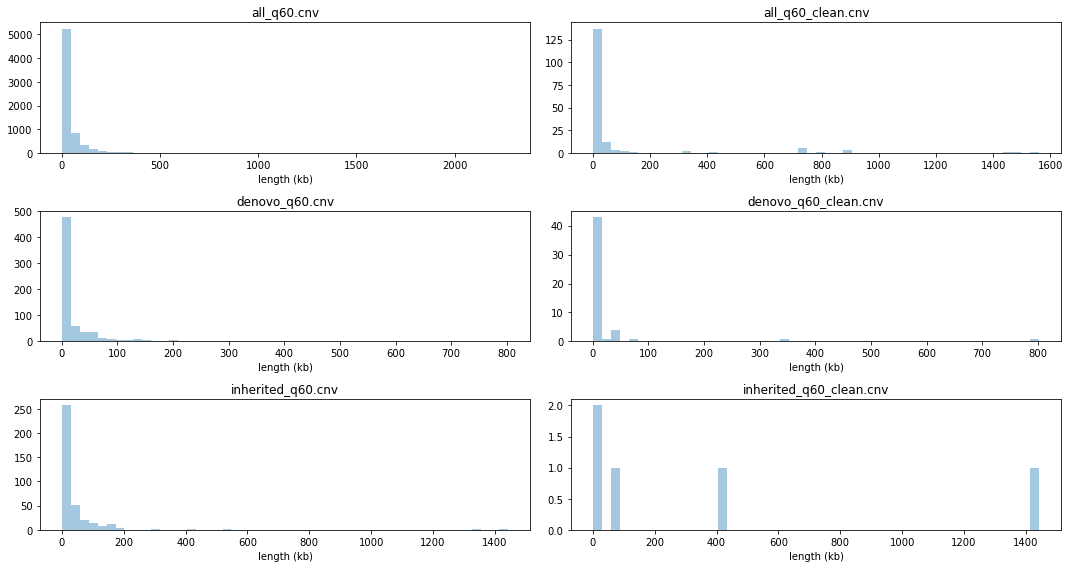

In [4]:
data_dir = '/home/sudregp/data/cnv/xhmm_clean/'
files = glob.glob(data_dir + '/*_q60*.cnv')
files.sort()
plt.figure(figsize=(15,8))
i = 1
for fname in files:
    if fname.find('DATA') < 0:
        plt.subplot(3, 2, i)
        # the clean files have a header
        if fname.find('clean') >= 0:
            df = pd.read_table(fname, header=None, skiprows=1, delimiter='\s+')
        else:
            df = pd.read_table(fname, header=None)
        sns.distplot((df[4]-df[3])/1000, kde=False, bins=50)
        plt.xlabel('length (kb)')
        plt.title(fname.split('/')[-1])
        i += 1
plt.tight_layout()

Yep, quite similar. So, let's generate the lenLT files:

In [5]:
%%bash

module load plink/1.07

cd ~/data/cnv/xhmm_clean
for q in 50 60 70 80 90; do
    for cnvtype in all denovo inherited; do
        for qc in '' '_clean'; do
            for kb in 250 500; do
                cnvname=${cnvtype}_q${q}${qc}.cnv
                # whole burden
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-check-no-overlap --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_burden;
                # gene sets
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset genes.txt --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_genes;
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_brainGenes;
                # subtypes only
                for sub in del dup; do
                    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-${sub} --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_${sub}Burden;
                    # gene sets
                    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                        --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                        --cnv-subset genes.txt --cnv-${sub} --cnv-max-kb $kb \
                        --out ${cnvtype}_q${q}${qc}_lenLT${kb}_${sub}Genes;
                    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                        --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                        --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-${sub} \
                        --cnv-max-kb $kb \
                        --out ${cnvtype}_q${q}${qc}_lenLT${kb}_${sub}BrainGenes;
                done;
            done;
        done;
    done;
done


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q50_lenLT250_burden.log ]
Analysis started: Fri Jan 26 15:41:44 2018

Options in effect:
	--map all_q50.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_q50.cnv
	--noweb
	--1
	--cnv-check-no-overlap
	--cnv-max-kb 250
	--out all_q50_lenLT250_burden

Reading marker information from [ all_q50.cnv.map ]
10101 (of 10101) markers to be included from [ all_q50.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Readi

Now it's time for the scatterplots:

In [2]:
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']

# cleaning up the data for this analysis
fid = open('/home/sudregp/data/cnv/exclude.txt', 'r')
exclude_list = [line.rstrip() for line in fid]
fid.close()
fid = open('/home/sudregp/data/cnv/exclude_multikids.txt', 'r')
exclude_list += [line.rstrip() for line in fid]
fid.close()

trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if (fa[:4] in wes_prefix and mo[:4] in wes_prefix and
        sid[:4] in wes_prefix and sid not in exclude_list):
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)
good_kids = [t['child'] for t in trios]

print 'Working with %d samples, in %d families' % (len(samples), len(famids))

Working with 88 samples, in 20 families


In [7]:
def plot_plink_cnvs(fname, t_str, verbose=False):
    
    import plotly.graph_objs as go
    from plotly import tools

    df = pd.read_table(fname, delimiter='\s+', index_col=1)
    df.head()

    x_red, x_green, red, green, xticks = [], [], [], [], []
    red_text, green_text = [], []

    # loop through families
    f = 0
    for fam in famids:
        fam_kids = [t['child'] for t in trios if t['famid'] == fam]
        found = False
        for kid in fam_kids:
            if kid in good_kids:
                found = True
                idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
                if kid in affected:
                    red.append(int(df.iloc[idx]['NSEG']))
                    x_red.append(f)
                    red_text.append(kid)
                else:
                    green.append(int(df.iloc[idx]['NSEG']))
                    x_green.append(f)
                    green_text.append(kid)
        # only increase counter if we added a kid
        if found:
            xticks.append(fam)
            f += 1

    fig = go.Figure()
                
    trace0 = go.Scatter(
        x = x_red,
        y = red,
        mode = 'markers',
        name = 'affected',
        marker = dict(size = 10, color = 'red'),
        text = red_text,
        hoverinfo='text+y',
        showlegend = True
    )
    trace1 = go.Scatter(
        x = x_green,
        y = green,
        mode = 'markers',
        name = 'unaffected',
        marker = dict(size = 10, color = 'green'),
        hovertext = green_text,
        hoverinfo='text+y',
        showlegend = True
    )
    fig['data'] = [trace0, trace1]
    fig['layout'].update(height=400, width=800, title=t_str,
                             xaxis1=dict(tickvals=range(len(xticks)),
                                        ticktext=xticks,
                                        zeroline = False),
                             hovermode='closest')
    iplot(fig)
    
    # print family order
    if verbose:
        score = []
        for x in range(max(x_green + x_red)):
            idx = [i for i, val in enumerate(x_red) if val == x]
            if len(idx) == 0:
                aff = 0
            else:
                aff = red[idx[0]]
            idx = [i for i, val in enumerate(x_green) if val == x]
            if len(idx) == 0:
                unaff = 0
            else:
                unaff = max([green[i] for i in idx])
            score.append(aff - unaff)
        order = np.argsort(score)[::-1]
        fam_names = fig.layout.xaxis1['ticktext']
        disrupted = [fam_names[v] for v in order if score[v] > 0]
        print 'Best disrupted:', ', '.join(disrupted)
        protected = [fam_names[v] for v in order[::-1] if score[v] < 0]
        print 'Best protected:', ', '.join(protected)

In [12]:
import glob

data_dir = '/home/sudregp/data/cnv/xhmm_clean/'
files = glob.glob(data_dir + '/denovo*q60*clean_lenLT250_???Genes*cnv.indiv')
files.sort()
for f in files:
    t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
    plot_plink_cnvs(f, t_str, verbose=True)

Best disrupted: 10406, 855, 10369, 10448
Best protected: 1895


Best disrupted: 10164, 10090
Best protected: 10131, 10369, 10448


Nice to see that most of our previous results are still here, even after the new (optional) cleaning procedures used in XHMM. Does the gene-based analysis show anything different?

In [17]:
fid = open('/home/sudregp/data/cnv/xhmm_clean/denovo_q60_clean_lenLT250_delGenes.reg')
genes = {}
for line in fid:
    if line.find('RANGE') >= 0:
        gene = line.split(' ')[-2]
        genes[gene] = 0
    elif line.find('DUP') > 0 or line.find('DEL') > 0:
        genes[gene] += 1
fid.close()
df = pd.DataFrame.from_dict(genes, orient='index')
df.columns = ['count']
df.sort_values(by='count', ascending=False).head(10)

,count
LCORL,2
ABHD13,2
CHD9,2
MED13,1
ETNK1,1
DNAJB14,1
CREBRF,1
CCDC168,1
LYSMD3,1
CCDC39,1


In [18]:
dfs = df.sort_values(by='count', ascending=False).head(3)
for index, count in dfs.iterrows():
    nlines = count[0]
    gene = index
    fid = open('/home/sudregp/data/cnv/xhmm_clean/denovo_q60_clean_lenLT250_delGenes.reg')
    for line in fid:
        if line.find(gene) >= 0:
            print line.rstrip()
            for i in range(nlines + 1):
                line = fid.next()
                print line.rstrip()
    fid.close()

RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400178        2    4     17845860     17879761    DEL     33.9        1   0.1898   0.1898
   1   CLIA_400204        2    4     17878089     17878822    DEL    0.733        1 0.004109 0.004109
RANGE (+/- 0kb )  [ 13 108870762 108886603 ABHD13 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400158        1   13    108882417    108886344    DEL    3.927        1   0.2479   0.2479
   1   CLIA_400178        2   13    108882844    108886540    DEL    3.696        1   0.2334   0.2334
RANGE (+/- 0kb )  [ 16 53088944 53361414 CHD9 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400178        2   16     53358611     53361477    DEL    2.866    0.978  0.01029  0.01029
   1   CLIA_400203        1   16    

In [4]:
fid = open('/home/sudregp/data/cnv/xhmm_clean/denovo_q60_clean_lenLT250_dupGenes.reg')
genes = {}
for line in fid:
    if line.find('RANGE') >= 0:
        gene = line.split(' ')[-2]
        genes[gene] = 0
    elif line.find('DUP') > 0 or line.find('DEL') > 0:
        genes[gene] += 1
fid.close()
df = pd.DataFrame.from_dict(genes, orient='index')
df.columns = ['count']
df.sort_values(by='count', ascending=False).head(10)

,count
ABHD13,3
XIST,1
POM121L2,1
SP3,1
CREBRF,1
REV3L,1
MGAT4A,1
ETNK1,1
NCAPG,1
LCORL,1


In [5]:
dfs = df.sort_values(by='count', ascending=False).head(1)
for index, count in dfs.iterrows():
    nlines = count[0]
    gene = index
    fid = open('/home/sudregp/data/cnv/xhmm_clean/denovo_q60_clean_lenLT250_dupGenes.reg')
    for line in fid:
        if line.find(gene) >= 0:
            print line.rstrip()
            for i in range(nlines + 1):
                line = fid.next()
                print line.rstrip()
    fid.close()

RANGE (+/- 0kb )  [ 13 108870762 108886603 ABHD13 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400122        2   13    108882417    108884732    DUP    2.315        1   0.1462   0.1462
   1   CLIA_400123        2   13    108882665    108885500    DUP    2.835        1    0.179    0.179
   1   CCGO_800979        1   13    108884227    108884732    DUP    0.505        1  0.03194  0.03194


Or maybe there's something to the genes where the del/dups are?

In [41]:
%%bash
for s in CLIA_400216 CLIA_400205 CCGO_800980 CLIA_400178; do
    echo $s
    grep -B 3 $s /home/sudregp/data/cnv/xhmm_clean/denovo_q60_clean_lenLT250_delGenes.reg | grep RANGE
done

CLIA_400216
RANGE (+/- 0kb )  [ X 139865424 139866723 CDR1 ]
CLIA_400205
RANGE (+/- 0kb )  [ 8 30689059 30706533 TEX15 ]
CCGO_800980
RANGE (+/- 0kb )  [ X 80369199 80457441 HMGN5 ]
CLIA_400178
RANGE (+/- 0kb )  [ 1 62901974 62917475 USP1 ]
RANGE (+/- 0kb )  [ 1 62920396 63154039 DOCK7 ]
RANGE (+/- 0kb )  [ 1 67390577 67454302 MIER1 ]
RANGE (+/- 0kb )  [ 1 93811477 93828148 DR1 ]
RANGE (+/- 0kb )  [ 2 48010220 48034092 MSH6 ]
RANGE (+/- 0kb )  [ 2 48034058 48132932 FBXO11 ]
RANGE (+/- 0kb )  [ 2 174771186 174830430 SP3 ]
RANGE (+/- 0kb )  [ 3 180319917 180336135 TTC14 ]
RANGE (+/- 0kb )  [ 3 180331795 180397283 CCDC39 ]
RANGE (+/- 0kb )  [ 4 17812435 17846487 NCAPG ]
RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
RANGE (+/- 0kb )  [ 4 68424445 68472616 STAP1 ]
RANGE (+/- 0kb )  [ 4 68481478 68566889 UBA6 ]
RANGE (+/- 0kb )  [ 4 100817406 100867883 DNAJB14 ]
RANGE (+/- 0kb )  [ 4 113152894 113191211 AP1AR ]
RANGE (+/- 0kb )  [ 5 65222381 65376851 ERBB2IP ]
RANGE (+/- 0kb )  [ 5 89689528

In [42]:
%%bash
for s in CLIA_400123 CLIA_400122; do
    echo $s
    grep -B 3 $s /home/sudregp/data/cnv/xhmm_clean/denovo_q60_clean_lenLT250_dupGenes.reg | grep RANGE
done

CLIA_400123
RANGE (+/- 0kb )  [ 4 17812435 17846487 NCAPG ]
RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
RANGE (+/- 0kb )  [ 12 22778075 22843608 ETNK1 ]
RANGE (+/- 0kb )  [ 13 108870762 108886603 ABHD13 ]
CLIA_400122
RANGE (+/- 0kb )  [ 2 99235568 99347589 MGAT4A ]
RANGE (+/- 0kb )  [ 2 174771186 174830430 SP3 ]
RANGE (+/- 0kb )  [ 5 172483354 172566291 CREBRF ]
RANGE (+/- 0kb )  [ 6 111620233 111804918 REV3L ]
RANGE (+/- 0kb )  [ 13 108870762 108886603 ABHD13 ]


In [43]:
fid = open('/home/sudregp/data/cnv/xhmm_clean/denovo_q60_clean_lenLT250_genes.reg')
genes = {}
for line in fid:
    if line.find('RANGE') >= 0:
        gene = line.split(' ')[-2]
        genes[gene] = 0
    elif line.find('DUP') > 0 or line.find('DEL') > 0:
        genes[gene] += 1
fid.close()
df = pd.DataFrame.from_dict(genes, orient='index')
df.columns = ['count']
df.sort_values(by='count', ascending=False).head(10)

,count
ABHD13,5
LCORL,3
NCAPG,2
CHD9,2
REV3L,2
ETNK1,2
SP3,2
CREBRF,2
CCDC39,1
STAP1,1


In [45]:
dfs = df.sort_values(by='count', ascending=False).head(8)
for index, count in dfs.iterrows():
    nlines = count[0]
    gene = index
    fid = open('/home/sudregp/data/cnv/xhmm_clean/denovo_q60_clean_lenLT250_genes.reg')
    for line in fid:
        if line.find(gene) >= 0:
            print line.rstrip()
            for i in range(nlines + 1):
                line = fid.next()
                print line.rstrip()
    fid.close()

RANGE (+/- 0kb )  [ 13 108870762 108886603 ABHD13 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400122        2   13    108882417    108884732    DUP    2.315        1   0.1462   0.1462
   1   CLIA_400158        1   13    108882417    108886344    DEL    3.927        1   0.2479   0.2479
   1   CLIA_400123        2   13    108882665    108885500    DUP    2.835        1    0.179    0.179
   1   CLIA_400178        2   13    108882844    108886540    DEL    3.696        1   0.2334   0.2334
   1   CCGO_800979        1   13    108884227    108884732    DUP    0.505        1  0.03194  0.03194
RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400123        2    4     17845860     17879030    DUP    33.17        1   0.1857   0.1857
   1   CLIA_400178        2    4     17845860     17879761    DEL     33.9        1 

This is a quite interesting result... I wonder if we can assess the stats of it somehow?

# Unclean

In [24]:
import glob

data_dir = '/home/sudregp/data/cnv/xhmm_clean/'
files = glob.glob(data_dir + '/denovo*q60_lenLT250_*Genes*cnv.indiv')
files.sort()
for f in files:
    t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
    plot_plink_cnvs(f, t_str, verbose=True)

Best disrupted: 10406, 1895, 10197
Best protected: 10128, 10215, 1976, 10448


Best disrupted: 10406
Best protected: 10128, 1976, 10215


Best disrupted: 10406, 10197, 10369, 10153, 10448, 10173, 10033, 10164, 10178
Best protected: 1976, 10094, 855, 10215, 10090, 10128, 10182, 1895, 1892


Best disrupted: 10197, 1895
Best protected: 10448


Best disrupted: 10090, 10173, 1895, 10033, 10164, 855, 10128, 10197, 10182, 10178
Best protected: 1976, 10131, 10448, 10369, 1892, 10153, 10094


The unclean results are continuous enough that we could try the correlation approach:

In [25]:
from itertools import combinations
from scipy import stats


def compute_correlations(files, diff=False, p_thresh=.05, x='ncnv', min_points=20):
    pcorrs = []
    scorrs = []
    ptitles, stitles = [], []
    for f in files:
        # open PLINK file and grab the burden for all kids
        df = pd.read_table(f, delimiter='\s+', index_col=1)
        kids = [t['child'] for t in trios]
        ncnv = []
        for kid in kids:
            idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
            ncnv.append(int(df.iloc[idx]['NSEG']))
        df3 = pd.DataFrame(ncnv, index=kids, columns=[x])
        data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
        data = pd.merge(data, df3, left_on='code', right_index=True)
        y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', x]]
        
        if diff:
            # the idea is to create a new data frame that only has the differences
            # among the phenotypes
            y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', 'ncnv']]
            # loop through families
            rows = []
            for fam in famids:
                fam_kids = [t['child'] for t in trios if t['famid'] == fam]
                # get all combinations of kids
                if len(fam_kids) > 1:
                    for kid1, kid2 in combinations(fam_kids, 2):
                        if kid1 in good_kids and kid2 in good_kids:
                            row1 = data[data['code'] == kid1]
                            row2 = data[data['code'] == kid2]
                            new_row = []
                            for y in (y_cols + [x]):
                                if np.float(row1[x]) > np.float(row2[x]):
                                    new_row.append(np.float(row1[y]) - 
                                                   np.float(row2[y]))
                                elif np.float(row2[x]) > np.float(row1[x]):
                                    new_row.append(np.float(row2[y]) - 
                                                   np.float(row1[y]))
                                else:
                                    new_row.append(np.nan)
                        rows.append(new_row)
            data = pd.DataFrame(rows, columns=(y_cols + [x]))

        # panda's corr() doesn't give p-vals, so let's do an ugly loop
        ps, ss = [], []
        for y in y_cols:
            tmp_df = data[[x, y]].dropna()
            r, p = stats.pearsonr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            # make sure we have enough points to compute a decent correlation
            if p > p_thresh or tmp_df.shape[0] < min_points:
                r = np.nan
            ps.append(r)
            r, p = stats.spearmanr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            if p > p_thresh or tmp_df.shape[0] < min_points:
                r = np.nan
            ss.append(r)
        # save the result if it's not NaN all across the board
        if not np.isnan(ps).all():
            pcorrs.append(ps)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            ptitles.append(t_str)
        if not np.isnan(ss).all():
            scorrs.append(ss)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            stitles.append(t_str)
            
    return (pd.DataFrame(pcorrs, index=ptitles, columns=y_cols),
            pd.DataFrame(scorrs, index=stitles, columns=y_cols))


# returns X and Y for a correlation plot
def get_xy(fname, ycol, diff=False, x='ncnv'):
    # open PLINK file and grab the burden for all kids
    df = pd.read_table(fname, delimiter='\s+', index_col=1)
    kids = [t['child'] for t in trios]
    ncnv = []
    for kid in kids:
        idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
        ncnv.append(int(df.iloc[idx]['NSEG']))
    df3 = pd.DataFrame(ncnv, index=kids, columns=[x])
    data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
    data = pd.merge(data, df3, left_on='code', right_index=True)
    
    if diff:
        # the idea is to create a new data frame that only has the differences
        # among the phenotypes
    
        # loop through families
        rows = []
        for fam in famids:
            fam_kids = [t['child'] for t in trios if t['famid'] == fam]
            # get all combinations of kids
            if len(fam_kids) > 1:
                for kid1, kid2 in combinations(fam_kids, 2):
                    if kid1 in good_kids and kid2 in good_kids:
                        row1 = data[data['code'] == kid1]
                        row2 = data[data['code'] == kid2]
                        if np.float(row1[x]) > np.float(row2[x]):
                            new_row = [np.float(row1[y]) - np.float(row2[y])
                                       for y in [ycol, x]]
                        elif np.float(row2[x]) > np.float(row1[x]):
                            new_row = [np.float(row2[y]) - np.float(row1[y])
                                       for y in [ycol, x]]
                        else:
                            new_row = [np.nan, np.nan]
                    rows.append(new_row)
        data = pd.DataFrame(rows, columns=[ycol, x])

    tmp_df = data[[x, ycol]].dropna()
    return tmp_df

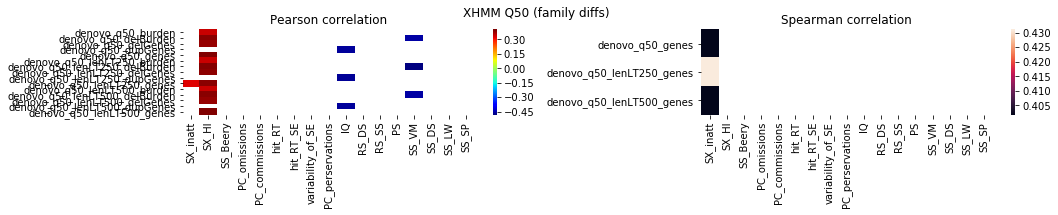

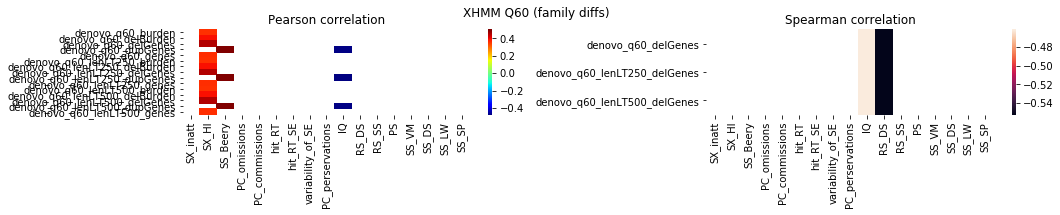

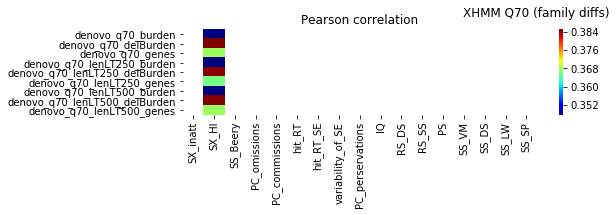

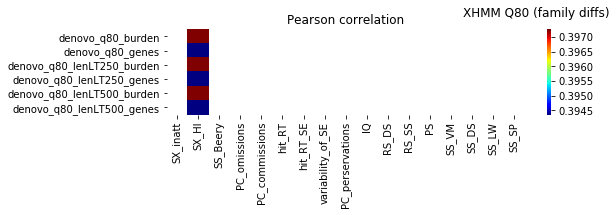

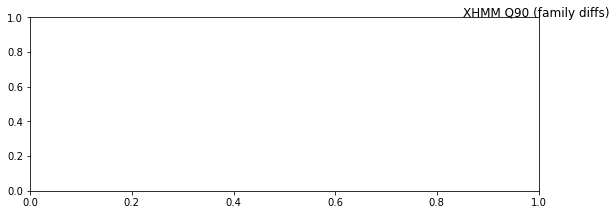

In [34]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm_clean/'
    files = [f for f in glob.glob(data_dir + '/*_q%d*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    files2 = [f for f in files if (f.find('denovo') >= 0 and 
                                   f.find('_clean_') < 0)] #and
#                                    (f.find('urden') >= 0 or f.find('genes') > 0))]# and
#                                    (f.find('dup') > 0 or f.find('del') > 0))]
    files2.sort()
    pcorrs, scorrs = compute_correlations(files2, diff=True, min_points=20, p_thresh=.05)
    
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d (family diffs)' % q)
    plt.tight_layout()
    plt.show()

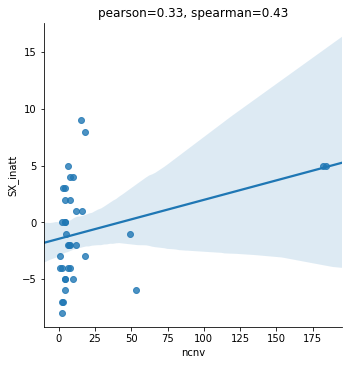

In [36]:
y='SX_inatt'
res=get_xy('/home/sudregp/data/cnv/xhmm_clean/denovo_q50_lenLT250_genes.cnv.indiv',
       y, diff=True, x='ncnv')
t_str = 'pearson=%.2f, spearman=%.2f' % (res.corr(method='pearson')['ncnv'][1],
                                         res.corr(method='spearman')['ncnv'][1])
sns.lmplot(x='ncnv', y=y, data=res)
plt.title(t_str)

We still need to remove 400178 for these correlations to make sense...